In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
rating_conv = json.load(open('../data_coll/rating_conv.json'))
rev_rating_conv = json.load(open('../data_coll/rev_rating_conv.json'))
routes = pd.read_csv('../data/routes.csv')
users = pd.read_csv('../data/user_ticks.csv', delimiter='|')
climbs = users.merge(routes, how='left', left_on='route_id', right_on='route_id')

In [15]:
sport_max = (climbs[(climbs['style'] == 'Lead')
                    & (climbs['type'] == 'Sport')
                    & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').aggregate(max).rename(columns={'num_rating': 'sport_max'}))
trad_max = (climbs[(climbs['style'] == 'Lead')
                   & (climbs['type'] == 'Trad')
                   & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').aggregate(max).rename(columns={'num_rating': 'trad_max'}))
boulder_max = (climbs[(climbs['type'] == 'Boulder')][['user_id','num_rating']]
                .groupby('user_id').aggregate(max).rename(columns={'num_rating': 'boulder_max'}))

sport_avg = (climbs[(climbs['style'] == 'Lead')
                    & (climbs['type'] == 'Sport')
                    & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').mean().rename(columns={'num_rating': 'sport_avg'}))
trad_avg = (climbs[(climbs['style'] == 'Lead')
                   & (climbs['type'] == 'Trad')
                   & (climbs['lead_style'] != 'Fell/Hung')][['user_id','num_rating']]
                .groupby('user_id').mean().rename(columns={'num_rating': 'trad_avg'}))
boulder_avg = (climbs[(climbs['type'] == 'Boulder')][['user_id','num_rating']]
                .groupby('user_id').mean().rename(columns={'num_rating': 'boulder_avg'}))

on = 'user_id'
how = 'outer'
climber_stats = sport_max.merge(trad_max, how=how, left_on=on, right_on=on)
climber_stats = climber_stats.merge(boulder_max, how=how, left_on=on, right_on=on)
climber_stats = climber_stats.merge(sport_avg, how=how, left_on=on, right_on=on)
climber_stats = climber_stats.merge(trad_avg, how=how, left_on=on, right_on=on)
# climber_stats = climber_stats.merge(boulder_avg, how=how, left_on=on, right_on=on)

climber_stats['max_sport_trad_diff'] = climber_stats['sport_max'] - climber_stats['trad_max']
climber_stats['avg_sport_trad_diff'] = climber_stats['sport_avg'] - climber_stats['trad_avg']
climber_stats['max_sport_higher'] = (climber_stats['max_sport_trad_diff']
                                               .apply(lambda x: x if np.isnan(x) else (1 if x>0 else 0)))
climber_stats['avg_sport_higher'] = (climber_stats['avg_sport_trad_diff']
                                               .apply(lambda x: x if np.isnan(x) else (1 if x>0 else 0)))

climber_stats.head()

,sport_max,trad_max,boulder_max,sport_avg,trad_avg,max_sport_trad_diff,avg_sport_trad_diff,max_sport_higher,avg_sport_higher
user_id,,,,,,,,,
10134,9.3,7.0,NaN,7.260000,6.200000,2.3,1.060000,1.0,1.0
10143,12.4,NaN,4.01,9.950000,NaN,NaN,NaN,NaN,NaN
10231,13.2,9.3,NaN,11.100000,9.300000,3.9,1.800000,1.0,1.0
10270,11.5,10.4,0.01,9.609412,7.917647,1.1,1.691765,1.0,1.0
10332,10.3,6.0,NaN,9.150000,6.000000,4.3,3.150000,1.0,1.0


/Users/edwinressegue/opt/miniconda3/envs/gal/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/edwinressegue/opt/miniconda3/envs/gal/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


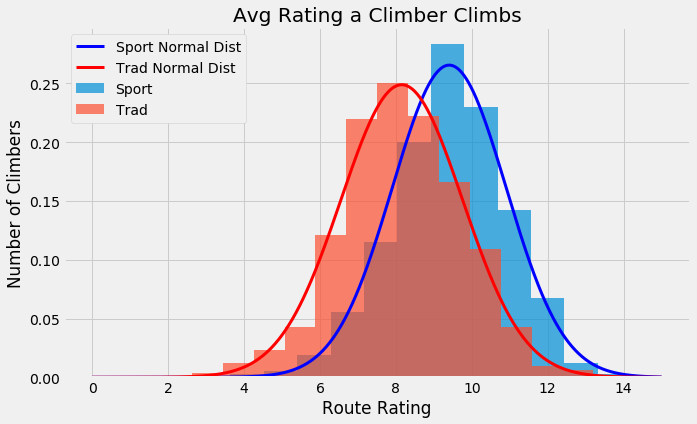

In [39]:
avg_sport = np.mean(climber_stats['sport_avg'])
var_sport = np.var(climber_stats['sport_avg'])
avg_trad = np.mean(climber_stats['trad_avg'])
var_trad = np.var(climber_stats['trad_avg'])
n_sport = len(climber_stats[climber_stats['sport_avg'].notnull()])
n_trad = len(climber_stats[climber_stats['trad_avg'].notnull()])

sport_norm_dist = stats.norm(avg_sport, np.sqrt(var_sport))
trad_norm_dist = stats.norm(avg_trad, np.sqrt(var_trad))
curve_x = np.linspace(0, 15, 10**4)

bins = 15
alpha = .7
lw = 3
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(climber_stats['sport_avg'], bins=bins, alpha=alpha, label='Sport', density=True);
ax.hist(climber_stats['trad_avg'], bins=bins, alpha=alpha, label='Trad', density=True);
ax.plot(curve_x, sport_norm_dist.pdf(curve_x), linewidth=lw, color='b', label='Sport Normal Dist');
ax.plot(curve_x, trad_norm_dist.pdf(curve_x), linewidth=lw, color='r', label='Trad Normal Dist');
ax.set_ylabel('Number of Climbers');
ax.set_xlabel('Route Rating');
ax.set_title('Avg Rating a Climber Climbs');
ax.legend(loc='upper left', framealpha=1);

plt.savefig('./images/climber_stats.png', bbox_inches='tight')